In [1]:
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoConfig,
    BitsAndBytesConfig
)
import bitsandbytes
from accelerate import infer_auto_device_map
from tqdm import tqdm
from datasets import Dataset, load_dataset
import torch
import random
import pandas as pd
import sys

from transformers.utils import logging as hf_logging
hf_logging.disable_progress_bar()

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [3]:
# from transformers import (
#     AutoTokenizer, AutoModelForCausalLM,
#     BitsAndBytesConfig
# )
# from datasets import Dataset, load_dataset
# import torch
# import random
import pandas as pd
# import nltk
# import ast
# import statistics
# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import numpy as np
# import warnings
# warnings.filterwarnings('ignore')

In [8]:
f = []
g = []
for ltype in ['it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate', 'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'it', 'jp-r-1-sov', 'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation', 'jp-u-2-invert', 'jp-u-3-past-tense', 'passive-sentence', 'sentence', 'subordinate-sentence']:
    f.append(pd.read_csv(f"llama-classification-train-test-det-{ltype}.csv").sort_values('type'))
    g.append(pd.read_csv(f"llama-classification-train-test-acc-{ltype}.csv").sort_values('type'))
    
f = pd.concat(f)
g = pd.concat(g)

f = f.sort_values('type')


fMistral = pd.read_csv('classification-train-test-det.csv').sort_values('type')
gMistral = pd.read_csv('classification-train-test-acc.csv').sort_values('type')

g = g.reset_index(drop=True)

gMistral = gMistral.reset_index(drop=True)
# gMistral.rename({'accuracy': 'accuracyMistral', 'type': 'typeMistral'}, axis=1, inplace=True)
# gMistral = gMistral.sort_values('typeMistral')
# f = pd.concat([f, fMistral], axis="columns")
# g = pd.concat([g, gMistral], axis="columns")

g = pd.concat([e.set_index(e['type']) 
           for e in [g, gMistral]], axis=1).reset_index(drop=True)

# f = pd.concat([e.set_index(e['type']) 
#            for e in [f, fMistral]], axis=1).reset_index(drop=True)


In [9]:
f.drop(['Unnamed: 0'], axis='columns', inplace=True)
g.drop(['Unnamed: 0'], axis='columns', inplace=True)
fMistral.drop(['Unnamed: 0'], axis='columns', inplace=True)
gMistral.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [10]:
g

,accuracy,type,accuracy,type
0,0.63,it-r-1-null_subject,0.83,it-r-1-null_subject
1,0.81,it-r-2-passive,0.83,it-r-2-passive
2,0.72,it-r-3-subordinate,0.81,it-r-3-subordinate
3,0.72,it-u-1-negation,0.79,it-u-1-negation
4,0.61,it-u-2-invert,0.77,it-u-2-invert
5,0.70,it-u-3-gender,0.76,it-u-3-gender
6,0.66,it,0.87,it
7,0.78,jp-r-1-sov,0.76,jp-r-1-sov
8,0.74,jp-r-2-passive,0.77,jp-r-2-passive
9,0.71,jp-r-3-subordinate,0.76,jp-r-3-subordinate


In [12]:
f

,type,prompt,q,prediction,gold,surprisal,int-grad
0,it,Q: Is this sentence grammatical? Yes or No: ho...,Q: Is this sentence grammatical? Yes or No: ko...,Yes,No,"[('kons', 12.104482650756836), ('kons', 12.104...",0
2,it,Q: Is this sentence grammatical? Yes or No: ko...,Q: Is this sentence grammatical? Yes or No: wo...,No,No,"[('women', 0), ('kars', 29.395511627197266), (...",0
3,it,Q: Is this sentence grammatical? Yes or No: wo...,Q: Is this sentence grammatical? Yes or No: ko...,Yes,Yes,"[('kon', 0), ('dog', 17.49838638305664), ('bri...",0
4,it,Q: Is this sentence grammatical? Yes or No: ca...,Q: Is this sentence grammatical? Yes or No: ta...,No,No,"[('takes', 0), ('boy', 13.099241256713867), ('...",0
5,it,Q: Is this sentence grammatical? Yes or No: ko...,Q: Is this sentence grammatical? Yes or No: ko...,Yes,Yes,"[('kon', 0), ('boy', 17.49838638305664), ('tak...",0
...,...,...,...,...,...,...,...
646,subordinate-sentence,Q: Is this sentence grammatical? Yes or No: Ha...,Q: Is this sentence grammatical? Yes or No: To...,Yes,Yes,"[('Tom', 0), ('notices', 27.608750343322754), ...",0
639,subordinate-sentence,Q: Is this sentence grammatical? Yes or No: Sh...,Q: Is this sentence grammatical? Yes or No: Jo...,No,No,"[('John', 0), ('states', 12.470088005065918), ...",0
629,subordinate-sentence,Q: Is this sentence grammatical? Yes or No: To...,Q: Is this sentence grammatical? Yes or No: Jo...,Yes,Yes,"[('John', 0), ('notices', 26.044504165649414),...",0
609,subordinate-sentence,Q: Is this sentence grammatical? Yes or No: Go...,Q: Is this sentence grammatical? Yes or No: Le...,Yes,Yes,"[('Leela', 12.672262191772461), ('Leela', 12.6...",0


In [11]:
s = g.columns.to_series().groupby(g.columns)


g.columns = np.where(s.transform('size')>1, 
                      g.columns + s.cumcount().add(1).astype(str), 
                      g.columns)

NameError: name 'np' is not defined

In [88]:
s = f.columns.to_series().groupby(f.columns)


f.columns = np.where(s.transform('size')>1, 
                      f.columns + s.cumcount().add(1).astype(str), 
                      f.columns)

In [1]:
g

NameError: name 'g' is not defined

<Figure size 1600x640 with 0 Axes>

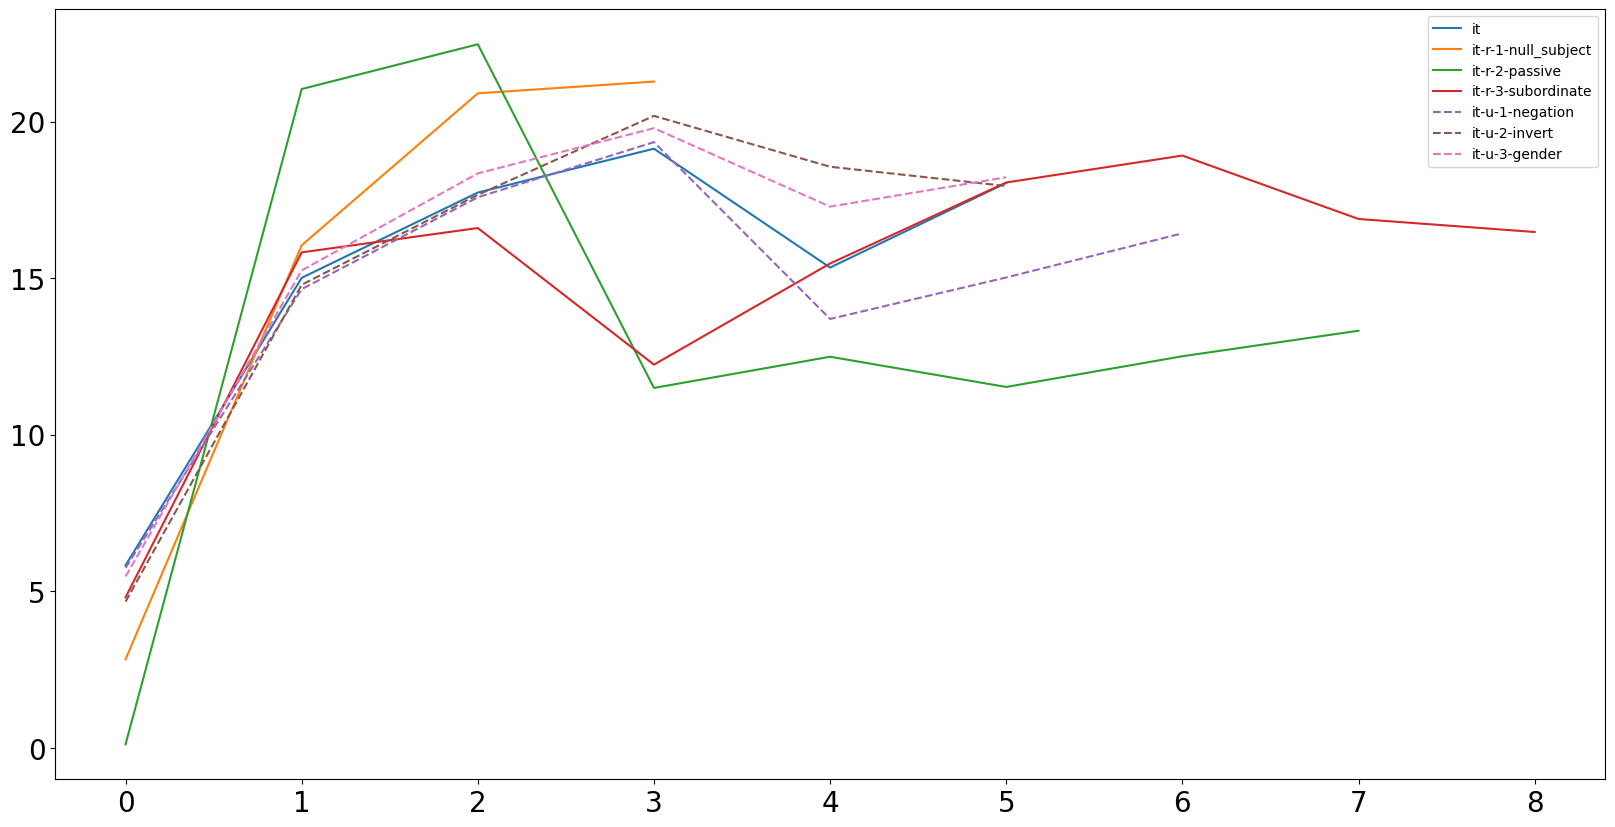

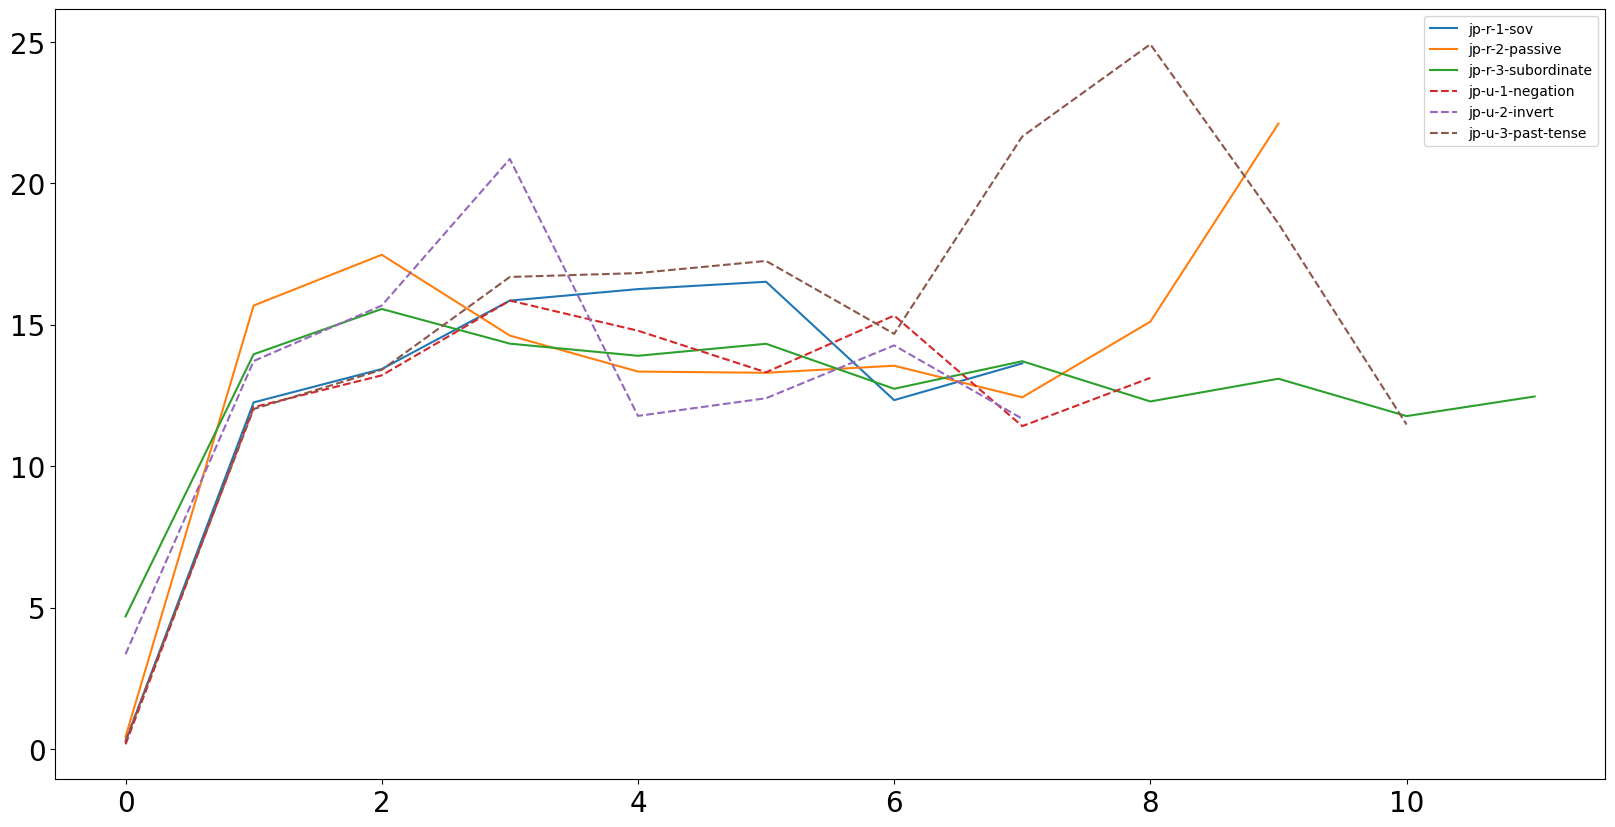

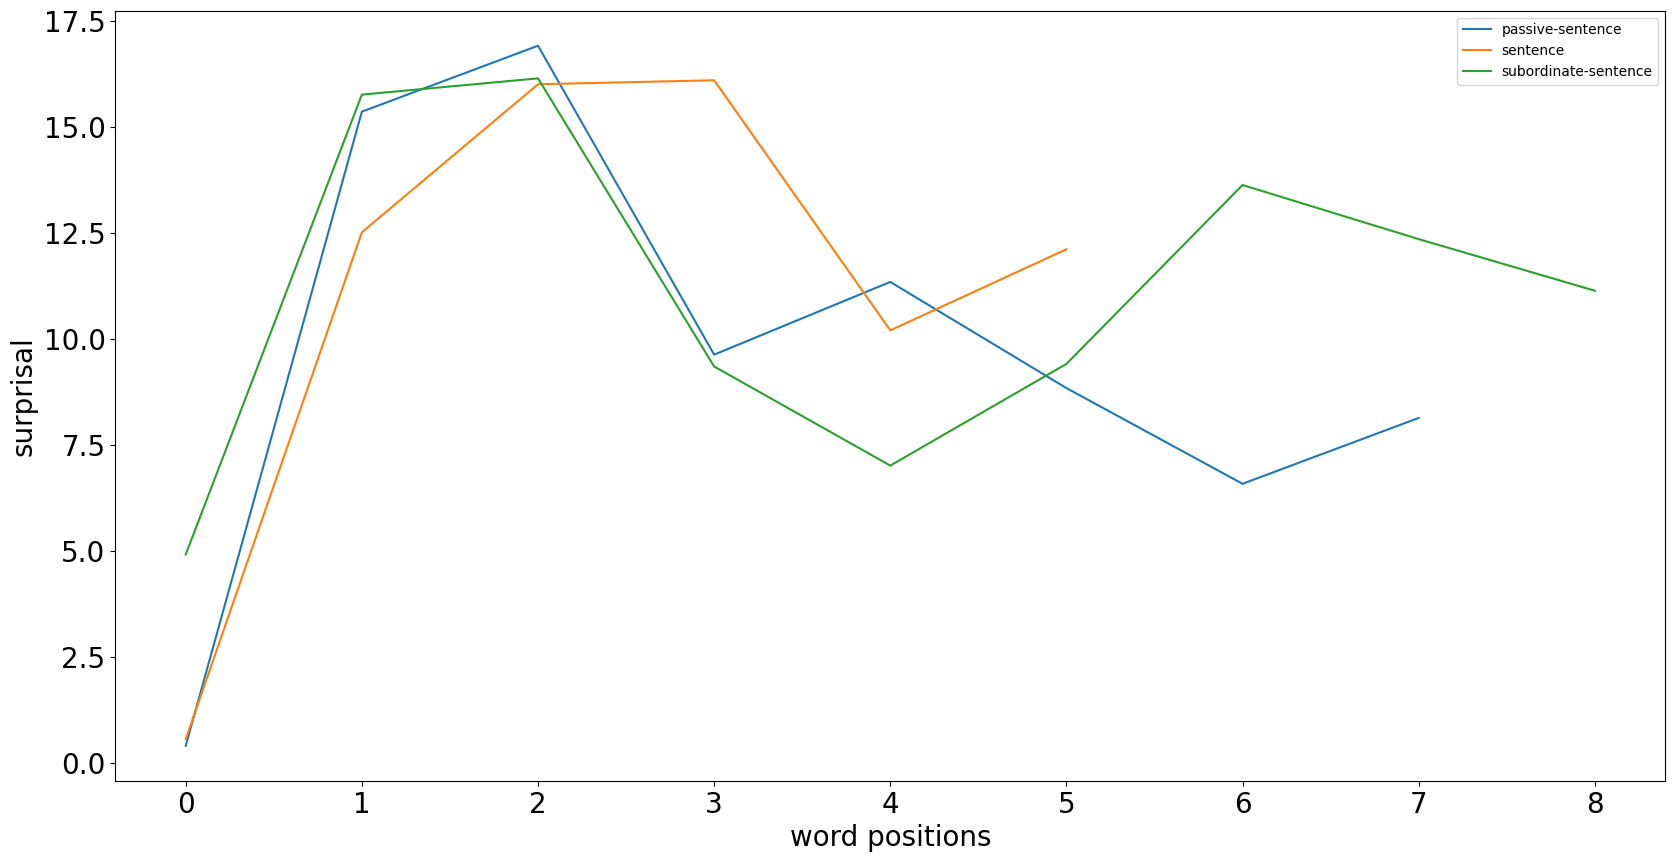

In [101]:
from matplotlib.pyplot import figure

figure(figsize=(20, 8), dpi=80)
x = list(range(12))
fig,iax=plt.subplots(figsize=(20, 10))
fig,jax=plt.subplots(figsize=(20, 10))
fig,eax=plt.subplots(figsize=(20, 10))
for sent_type in sorted(f['type'].unique()):
    surps = []
    for idx, row in f[f['type'] == sent_type].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    # print(transformed_surps)
    avg_surp = np.mean(transformed_surps, axis=1)

    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 10}

    matplotlib.rc('font', **font)
    y = avg_surp.tolist()
    for i in range(len(y), len(x)): 
        y.append(np.nan)  # Adding missing values
    nan_indices = [index for index, value in enumerate(y) if np.isnan(value)]
    nan_x = [i for i in nan_indices]
    nan_y = [0 for i in nan_indices]
    # print(len(y), len(x), nan_indices)
    if 'it' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            iax.plot(x, y, '--', label=sent_type)
        else:
            iax.plot(x, y, label=sent_type)
    elif 'jp' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            jax.plot(x, y, '--', label=sent_type)
        else:
            jax.plot(x, y, label=sent_type)
    else:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            eax.plot(x, y, '--', label=sent_type)
        else:
            eax.plot(x, y, label=sent_type)

plt.xlabel("word positions")
plt.ylabel("surprisal")
iax.legend()
jax.legend()
eax.legend()
plt.show()

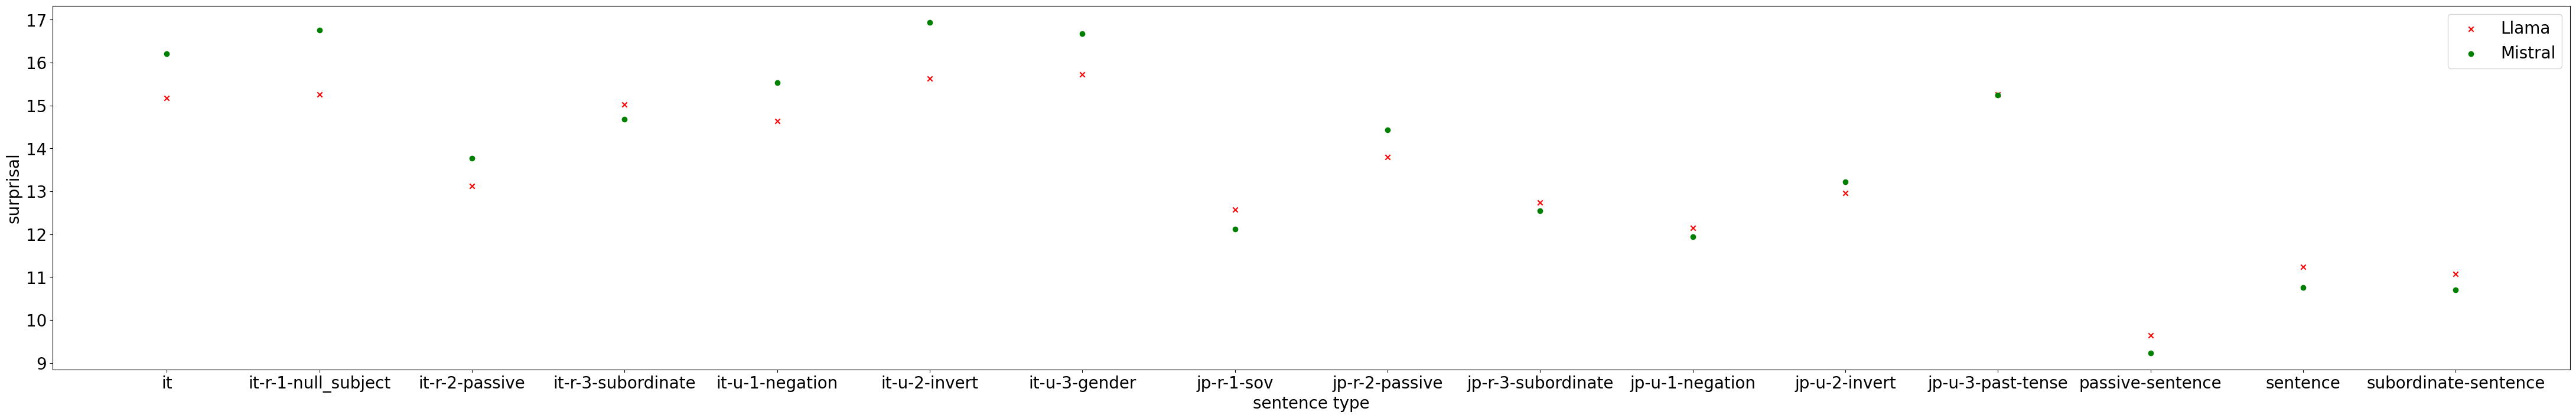

<Figure size 640x480 with 0 Axes>

In [100]:
x = []
y = []

xMistral = []
yMistral = []

fig, ax = plt.subplots(figsize=(55, 8))

for sent_type in sorted(f['type'].unique()):
    surps = []
    for idx, row in f[f['type'] == sent_type].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    avg_surp = np.mean(transformed_surps)
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 12}

    x.append(sent_type)
    y.append(avg_surp)

for sent_type in sorted(fMistral['type'].unique()):
    surps = []
    for idx, row in fMistral[fMistral['type'] == sent_type].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    avg_surp = np.mean(transformed_surps)
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    xMistral.append(sent_type)
    yMistral.append(avg_surp)


matplotlib.rc('font', **font)
plt.scatter(x,y, marker='x', color='red', label='Llama')
plt.scatter(xMistral,yMistral, marker='o', color='green', label='Mistral')
plt.xlabel("sentence type")
plt.ylabel("surprisal")
fig = plt.gcf()
plt.legend()
plt.show()
plt.draw()
fig.savefig(f'llama-surp.png', bbox_inches='tight')


In [ ]:


from nnsight import LanguageModel
import torch
import einops
import circuitsvis as cv

LLAMA_PATH = '/home/gridsan/arunas/broca/llama'
TOKENIZER_PATH = '/home/gridsan/arunas/broca/llama'
# LLAMA_PATH = '/home/gridsan/arunas/models/mistralai/Mistral-7B-v0.1/'
# TOKENIZER_PATH = '/home/gridsan/arunas/tokenizers/mistralai/Mistral-7B-v0.1/'

model_path = f"{LLAMA_PATH}/llama-model"
tokenizer_path = f'{TOKENIZER_PATH}/llama-tokenizer'
config = AutoConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path, config=config, device_map="auto", padding_side="left"
)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(f'{model_path}', device_map="auto", quantization_config=nf4_config)

# model = LanguageModel("gpt2", device_map='cuda:0', dispatch=True)

prompts = ['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to', 'When Tom and James went to the park, James gave the ball to', 'When Tom and James went to the park, Tom gave the ball to', 'When Dan and Sid went to the shops, Sid gave an apple to', 'When Dan and Sid went to the shops, Dan gave an apple to', 'After Martin and Amy went to the park, Amy gave a drink to', 'After Martin and Amy went to the park, Martin gave a drink to']
answers = [(' Mary', ' John'), (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]

clean_tokens = model.tokenizer(prompts, return_tensors="pt")['input_ids']
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]

answer_token_indices = torch.tensor([[model.tokenizer(answers[i][j])['input_ids'][0] for j in range(2)] for i in range(len(answers))], device=model.local_model.device)

def ioi_metric(logits,  CLEAN_BASELINE, CORRUPTED_BASELINE, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

with model.forward(inference=False) as runner:
    with runner.invoke(clean_tokens) as invoker:
        
        clean_logits = model.lm_head.output

        clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()

        clean_cache = [model.transformer.h[i].attn.attn_dropout.input.save() for i in range(len(model.transformer.h))]

        clean_grad_cache = [model.transformer.h[i].attn.attn_dropout.backward_input.save() for i in range(len(model.transformer.h))]

    with runner.invoke(corrupted_tokens) as invoker:
        
        corrupted_logits = model.lm_head.output

        corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()

        corrupted_cache = [model.transformer.h[i].attn.attn_dropout.input.save() for i in range(len(model.transformer.h))]
 
        corrupted_grad_cache = [model.transformer.h[i].attn.attn_dropout.backward_input.save() for i in range(len(model.transformer.h))]

        clean_value = ioi_metric(clean_logits, clean_logit_diff, corrupted_logit_diff).save()

        corrupted_value = ioi_metric(corrupted_logits, clean_logit_diff, corrupted_logit_diff).save()

        (corrupted_value + clean_value).backward()

clean_cache = torch.stack([value.value[0] for value in clean_cache])
clean_grad_cache = torch.stack([value.value[0] for value in clean_grad_cache])
corrupted_cache = torch.stack([value.value[0] for value in corrupted_cache])
corrupted_grad_cache = torch.stack([value.value[0] for value in corrupted_grad_cache])

print("Clean Value:", clean_value.value.item())
print("Corrupted Value:", corrupted_value.value.item())

def create_attention_attr(clean_cache, clean_grad_cache):
    attention_attr = clean_grad_cache * clean_cache
    attention_attr = einops.rearrange(attention_attr, "layer batch head_index dest src -> batch layer head_index dest src")
    return attention_attr

attention_attr = create_attention_attr(clean_cache, clean_grad_cache)

n_layers = len(model.transformer.h)
n_heads = model.transformer.h[0].attn.num_heads

HEAD_NAMES = [f"L{l}H{h}" for l in range(n_layers) for h in range(n_heads)]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

def plot_attention_attr(attention_attr, tokens, top_k=20, index=0, title=""):
    if len(tokens.shape)==2:
        tokens = tokens[index]
    if len(attention_attr.shape)==5:
        attention_attr = attention_attr[index]
    attention_attr_pos = attention_attr.clamp(min=-1e-5)
    attention_attr_neg =  - attention_attr.clamp(max=1e-5)
    attention_attr_signed = torch.stack([attention_attr_pos, attention_attr_neg], dim=0)
    attention_attr_signed = einops.rearrange(attention_attr_signed, "sign layer head_index dest src -> (layer head_index sign) dest src")
    attention_attr_signed = attention_attr_signed / attention_attr_signed.max()
    attention_attr_indices = attention_attr_signed.max(-1).values.max(-1).values.argsort(descending=True)
    # print(attention_attr_indices.shape)
    # print(attention_attr_indices)
    attention_attr_signed = attention_attr_signed[attention_attr_indices, :, :]
    head_labels = [HEAD_NAMES_SIGNED[i.item()] for i in attention_attr_indices]

    tokens = [model.tokenizer.decode(token) for token in tokens]

    return cv.circuitsvis.attention.attention_heads(tokens=tokens, attention=attention_attr_signed[:top_k], attention_head_names=head_labels[:top_k])

plot_attention_attr(attention_attr, clean_tokens, index=0, title="Attention Attribution for first sequence")
plot_attention_attr(attention_attr, clean_tokens, index=0, title="Attention Attribution for first sequence")